In [83]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datasetsforecast.losses import mae, mape, mase, rmse, smape
from sklearn.metrics import mean_absolute_percentage_error

In [84]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")
df.head()

,Timestamp,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,USDCUSDT,XRPUSDT,DOGEUSDT,ADAUSDT,SHIBUSDT,AVAXUSDT
0,1/1/2021,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69
1,1/2/2021,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33
2,1/3/2021,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05
3,1/4/2021,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71
4,1/5/2021,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53


In [85]:
df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'ds', 'BTCUSDT': 'y'})
df_selected = df_selected.dropna()
print(df_selected)

             ds         y
0      1/1/2021  29331.69
1      1/2/2021  32178.33
2      1/3/2021  33000.05
3      1/4/2021  31988.71
4      1/5/2021  33949.53
...         ...       ...
1240  5/25/2024  69290.57
1241  5/26/2024  68507.67
1242  5/27/2024  69436.43
1243  5/28/2024  68398.39
1244  5/29/2024  67652.42

[1245 rows x 2 columns]


In [86]:
df_selected["unique_id"]="1"
df_selected.columns=["ds", "y", "unique_id"]
df_selected.head()

,ds,y,unique_id
0,1/1/2021,29331.69,1
1,1/2/2021,32178.33,1
2,1/3/2021,33000.05,1
3,1/4/2021,31988.71,1
4,1/5/2021,33949.53,1


In [87]:
print(df_selected.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


In [88]:
df_selected["ds"] = pd.to_datetime(df_selected["ds"])
print(df_selected.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


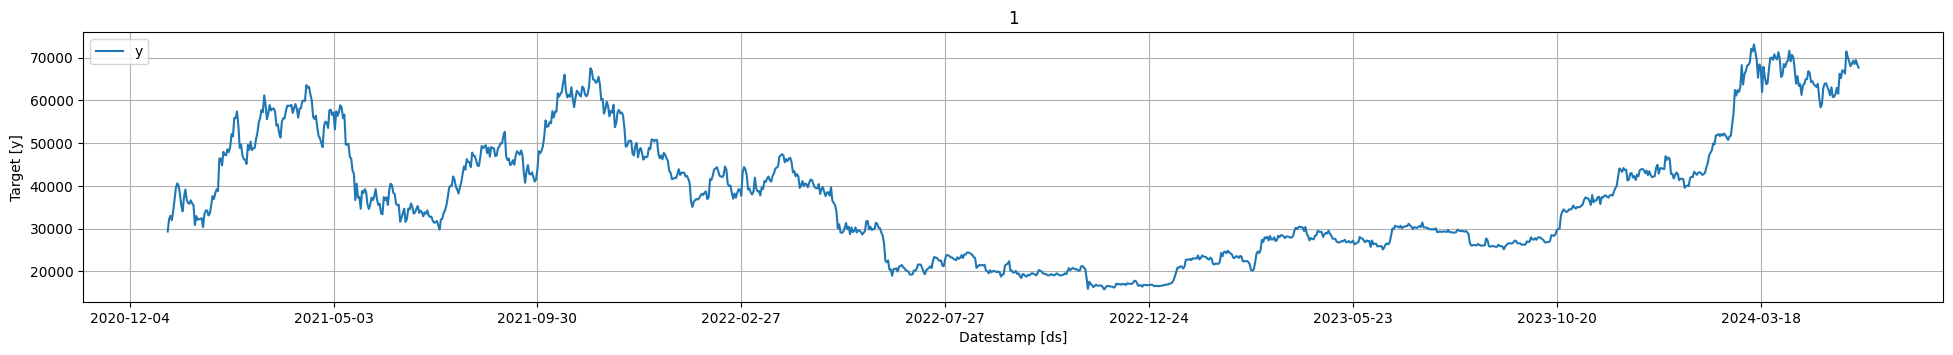

In [89]:
StatsForecast.plot(df_selected, engine="matplotlib")

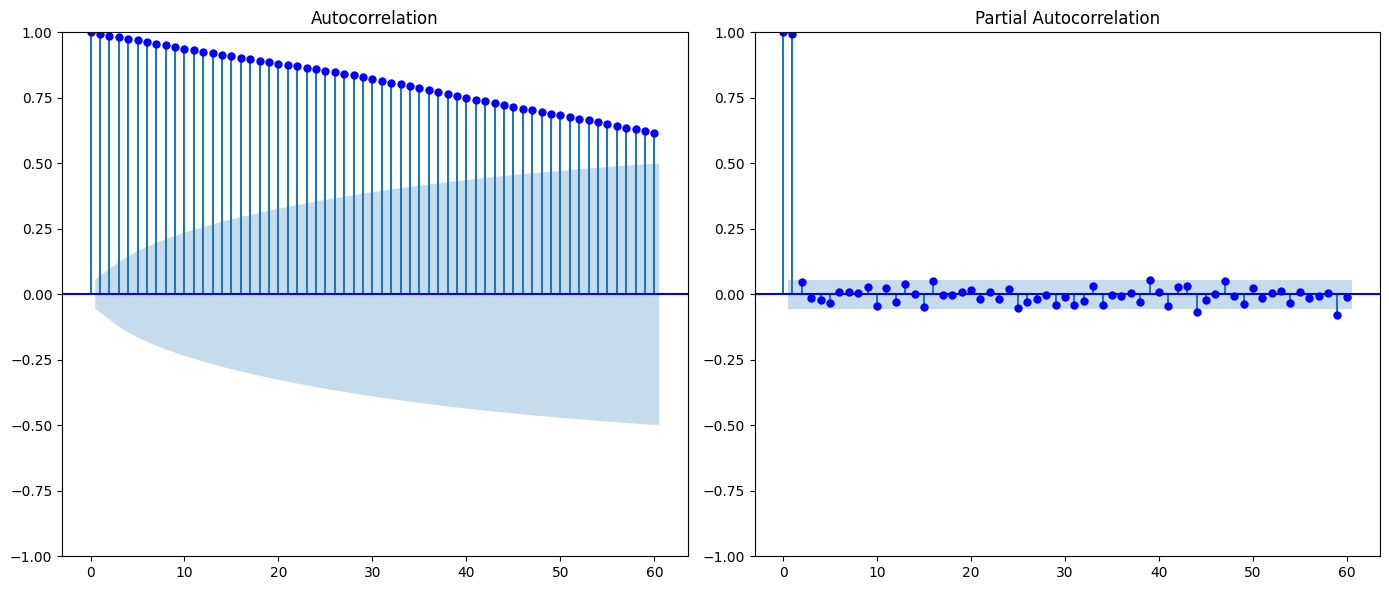

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelation")
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

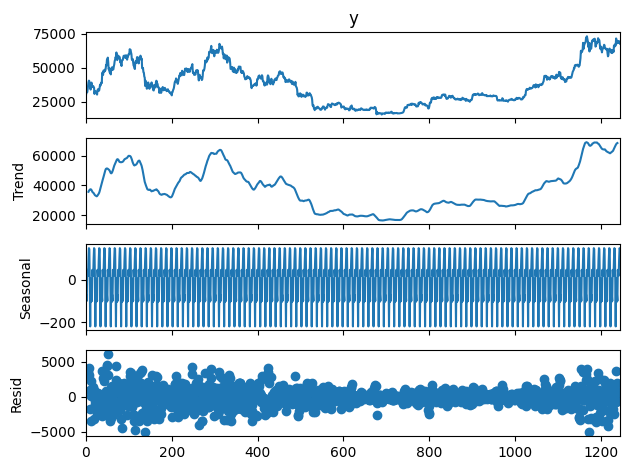

In [91]:
decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

In [92]:
Y_train_df = df_selected[df_selected.ds<='2024-05-01']
Y_test_df = df_selected[df_selected.ds>'2024-05-01']
Y_train_df.shape, Y_test_df.shape

((1217, 3), (28, 3))

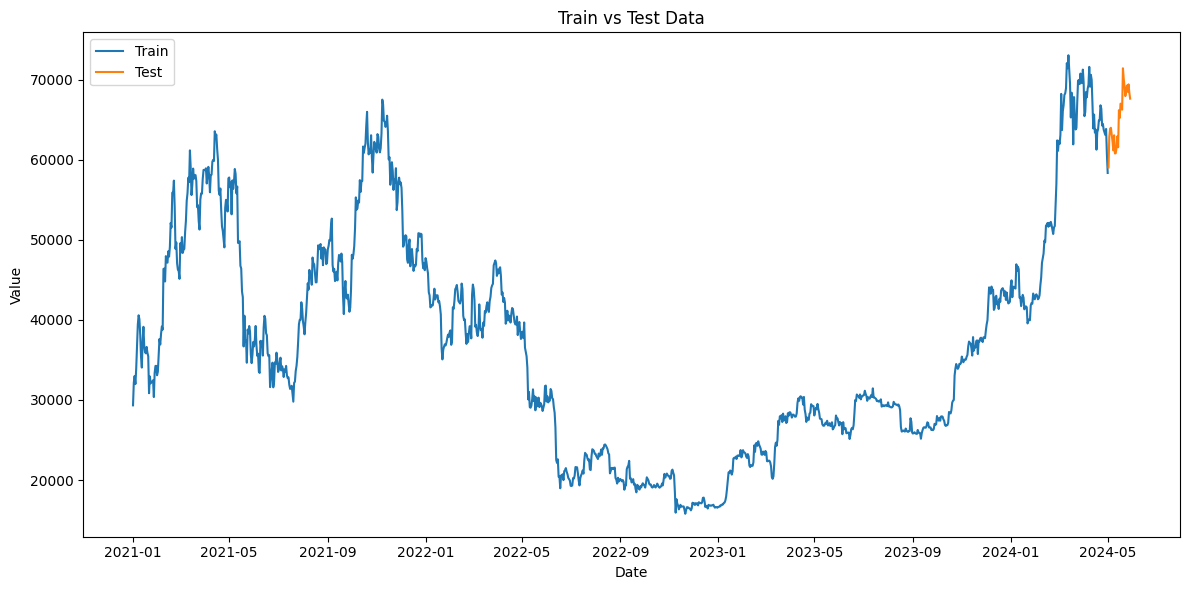

In [93]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=Y_train_df, x="ds", y="y", label="Train")
sns.lineplot(data=Y_test_df, x="ds", y="y", label="Test")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train vs Test Data")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
season_length = 12
horizon = len(Y_test_df) 
models = [AutoARIMA(season_length=season_length)]

In [95]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D',
                   n_jobs=-1)

In [96]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [97]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)(2,0,0)[12]                   '

In [98]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 2, 0, 12, 1, 0)


In [99]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,29.331675
1,2829.973518
2,1004.531646
3,-953.934743
4,1887.504910
...,...
1212,-491.089142
1213,-506.649022
1214,613.117352
1215,-3092.091434


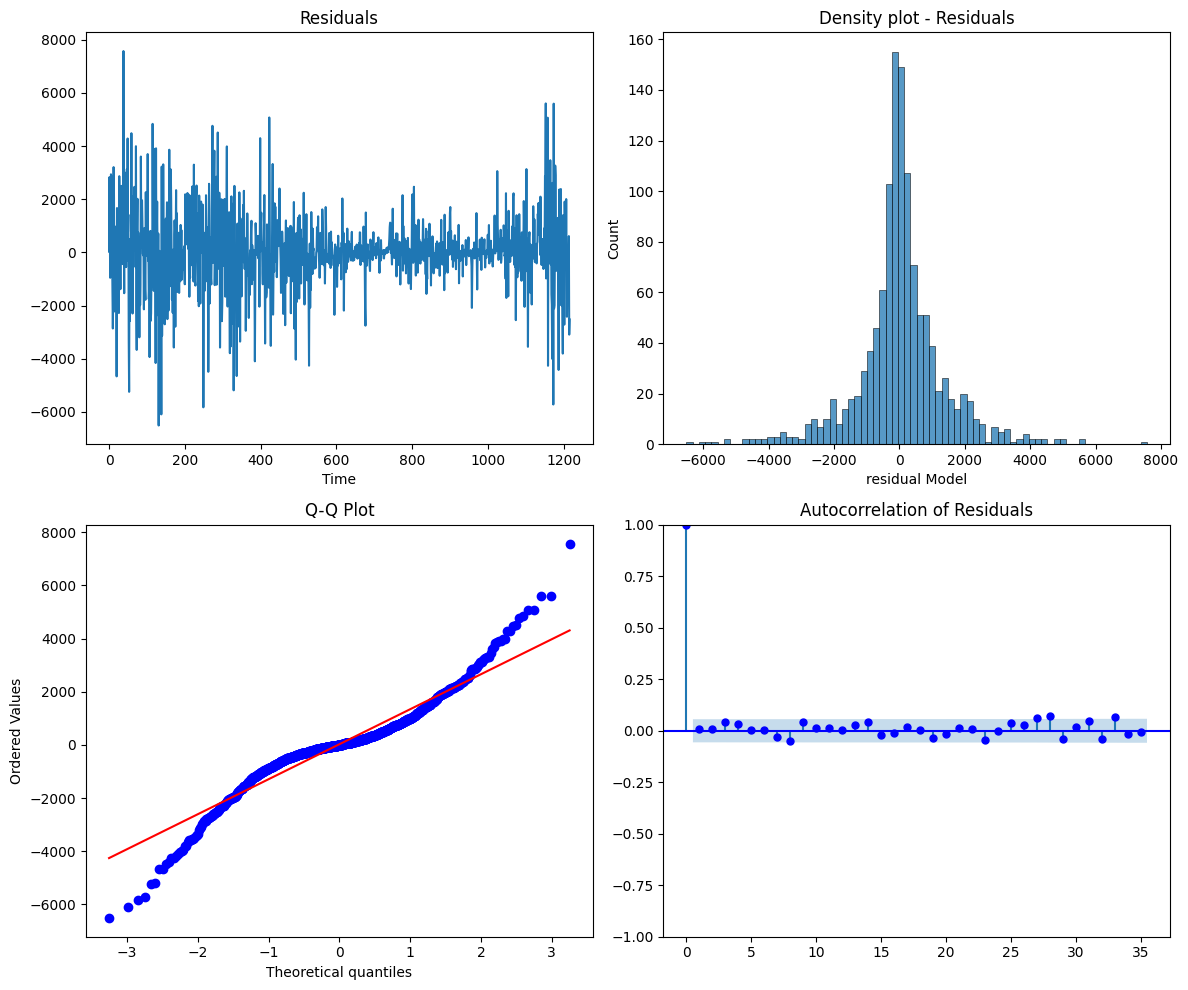

In [100]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
residual['residual Model'].plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuals")
axs[0, 0].set_xlabel('Time')

sns.histplot(residual['residual Model'], ax=axs[0, 1])
axs[0, 1].set_title("Density plot - Residuals")

stats.probplot(residual['residual Model'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

plot_acf(residual['residual Model'], lags=35, ax=axs[1, 1], color="blue")
axs[1, 1].set_title("Autocorrelation of Residuals")
plt.tight_layout()
plt.show()

In [101]:
Y_hat_df = sf.forecast(horizon, fitted=True)
Y_hat_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


,ds,AutoARIMA
unique_id,,
1,2024-05-02,58590.480469
1,2024-05-03,58429.542969
1,2024-05-04,58413.492188
1,2024-05-05,58398.480469
1,2024-05-06,58343.546875


In [102]:
forecast_df = sf.forecast(h=28, level = [95])
forecast_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2024-05-02,58590.480469,55903.421875,61277.542969
1,2024-05-03,58429.542969,54751.902344,62107.179688
1,2024-05-04,58413.492188,53953.906250,62873.074219
1,2024-05-05,58398.480469,53275.304688,63521.656250
1,2024-05-06,58343.546875,52633.363281,64053.734375
1,2024-05-07,58136.851562,51894.617188,64379.085938
1,2024-05-08,58284.476562,51552.109375,65016.843750
1,2024-05-09,58165.281250,50976.121094,65354.441406
1,2024-05-10,58207.687500,50589.070312,65826.304688


In [103]:
df_plot=pd.concat([df_selected, forecast_df]).set_index('ds').tail(75)
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
ds,,,,,
2024-04-13,63924.51,1,NaN,NaN,NaN
2024-04-14,65661.84,1,NaN,NaN,NaN
2024-04-15,63419.99,1,NaN,NaN,NaN
2024-04-16,63793.39,1,NaN,NaN,NaN
2024-04-17,61277.37,1,NaN,NaN,NaN
...,...,...,...,...,...
2024-05-25,NaN,NaN,58141.457031,46103.242188,70179.671875
2024-05-26,NaN,NaN,58152.042969,45846.628906,70457.453125
2024-05-27,NaN,NaN,58141.695312,45577.058594,70706.328125


/var/folders/dt/cxyz36h16ydfv1yg6n6v5fqm0000gn/T/ipykernel_21240/1513765931.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_plot.index, df_plot['AutoARIMA'], 'b-', label="AutoARIMA Forecast", linewidth=2, color="red")


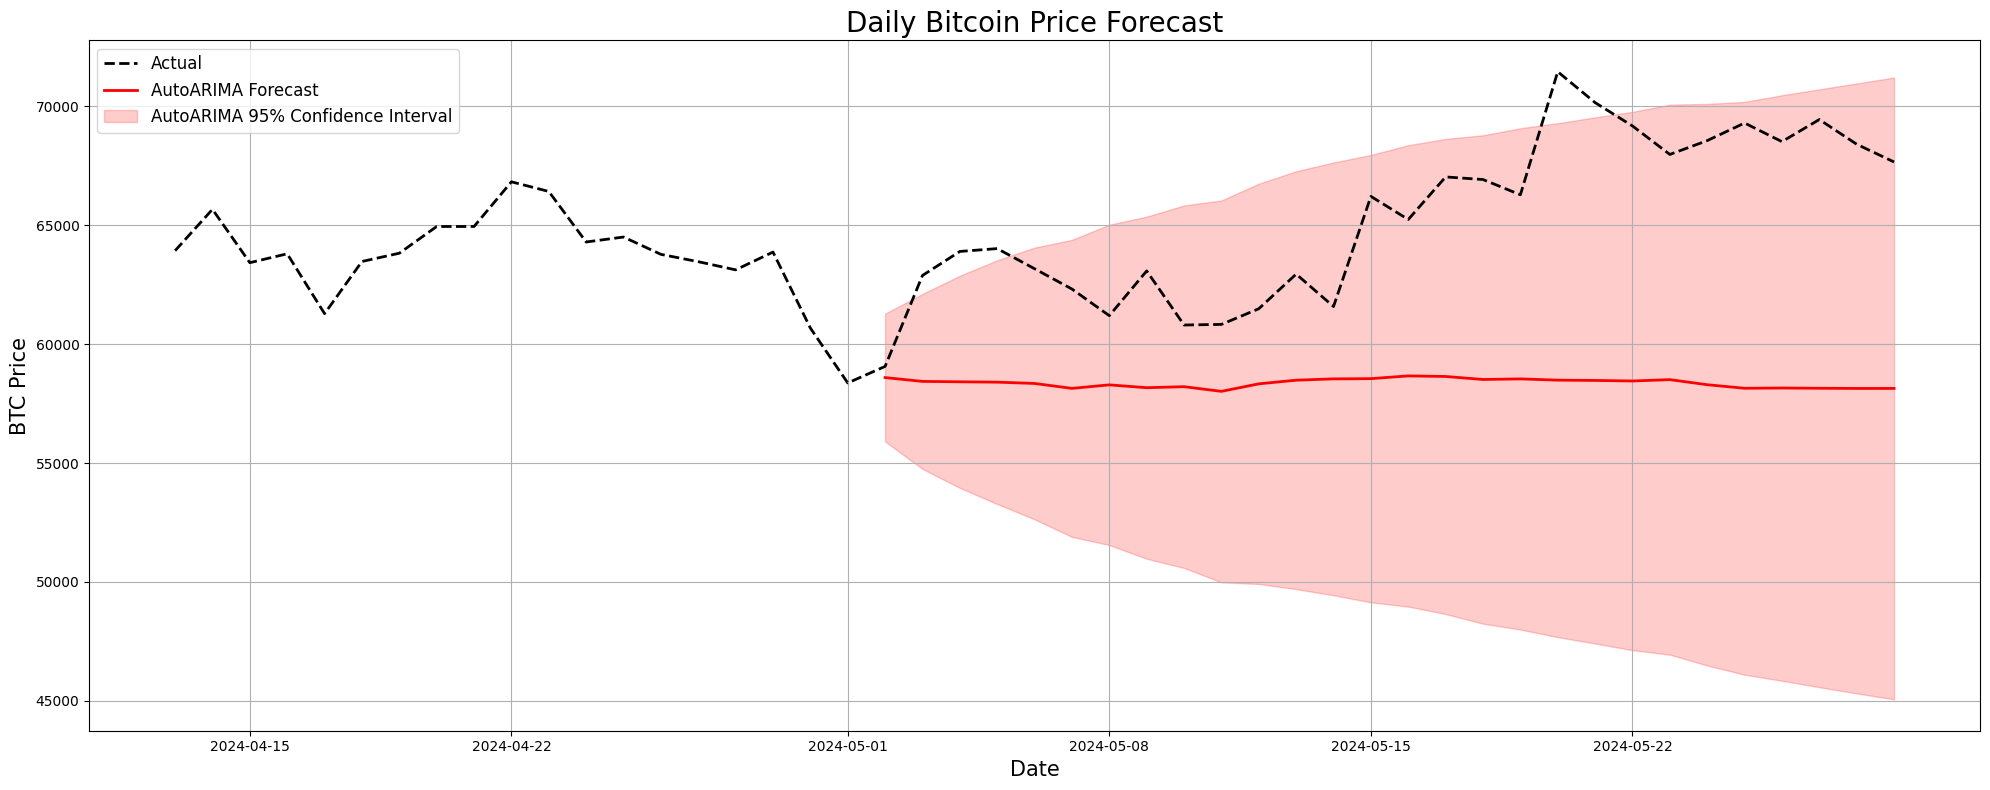

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

plt.plot(df_plot.index, df_plot['y'], 'k--', label="Actual", linewidth=2)
plt.plot(df_plot.index, df_plot['AutoARIMA'], 'b-', label="AutoARIMA Forecast", linewidth=2, color="red")
ax.fill_between(df_plot.index,
df_plot['AutoARIMA-lo-95'],
df_plot['AutoARIMA-hi-95'],
alpha=.2,
color='red',
label='AutoARIMA 95% Confidence Interval')

ax.set_title('Daily Bitcoin Price Forecast', fontsize=20)
ax.set_ylabel('BTC Price', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.legend(prop={'size': 12})
ax.grid(True)

plt.tight_layout()
plt.show()

In [105]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=12,
                                         n_windows=5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [109]:
smape = smape(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("SMAPE using cross-validation: ", mape)

MAPE using cross-validation:  5.469073727726936


In [113]:
mae = mae(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("MAE using cross-validation: ", mape)

MAE using cross-validation:  3653.2817


In [107]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  4674.5586
